#  Paper Information

- __Paper title__: An Empirical Study of CLIP for Text-based Person Search
- __Date Published__: 19/8/2023
- __Link github__: https://github.com/Flame-Chasers/TBPS-CLIP
- __Link paper__: https://arxiv.org/pdf/2308.10045v1.pdf
- __Conference__: *not yet*
- Why should research paper?
    - This paper belongs to the authors of RaSa (IJCAI - a rank-A conference)
    - Performance on benchmarks is better than IRRA 's (CVPR 2023)
    - Only finetune CLIP without adding any modules
    - Just focus on data augmentation, losses and training tricks

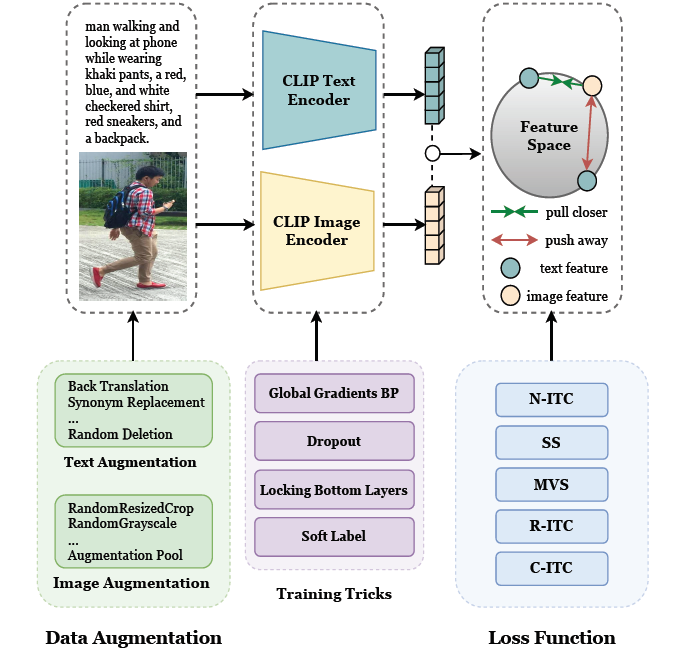

# Main contribution

- Design new image augmentation strategy based that beats the SOTA augmentation method from some papers

- Design some efficients loss functions for contrastive learning: total 5 losses

- Do an empirical analysis of the effect of training tricks, augmentation, loss on performance of CLIP

# Training tricks

__Global gradients back-propagation__

In multi-GPU training scenarios:
- The common choice is to only backpropagate the gradient of the loss functions from a local GPU while discarding the gradients gathered from other GPUs

- Instead of that, this paper __do__ back-propagating all gradients across GPUs will gain a *significant improvement* in performance !

__Drop out__

- Dropout is the method that randomly setting some of the neurons’ outputs to zero during model training.

- In this paper, apply it to the self-attention modules of the
text encoder with a probability of 0.05

__Locking bottom layers__

- Frozen the patch embedding module which convert image into sequence of patch embeddings

__Soft Label__

- Draw inspiration from paper ALBEF (also backbone of RaSa)
- Apply the soft label to the loss function. 
    - Let the pseudo-label represent the matching probability between the image and text, as output from the model. (the softmax-scaled of similarity score)
                $$ \mathcal{p_{i2t}}(I, T) = \frac{ \exp(s(F_I, F_{T^{+}})/ \tau) } {\exp(s(F_I, F_{T^{+}})/ \tau) + \exp(s(F_I, F_{T^{-}})/ \tau)} $$
    - The soft label is then the average value of the pseudo-label and ground-truth label.
    $$y_{soft}(I, T) = \frac{y_{ground_true}(I, T) + \mathcal{p_{i2t}}(I, T)}{2}$$
    --> Use this label as ground-true vector in cross-entropy loss

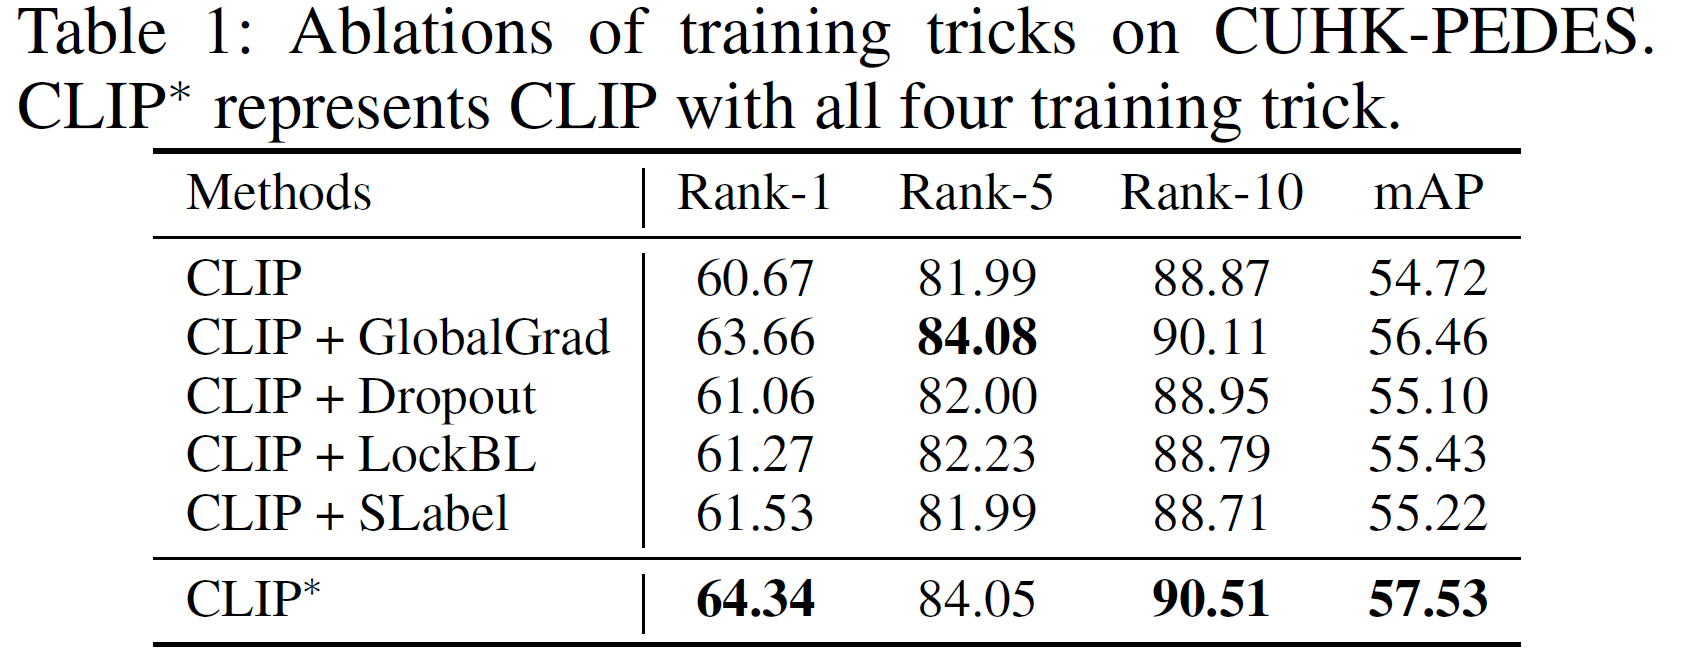

# Data Augmentation

## Image Augmentation

- Design new simple image augmentation strategy named __Augmentation Pool__: just randomly choose 2 augmentation methods from a pool $N$ of 4 augmentations method. 
- These $N$ augmentation methods can be divided into 2 groups:
    - Group of removal:
        - __RandomResizedCrop__
        - __RandomErasing__: 
            - From paper "Random Erasing Data Augmentation", CVPR 2017
            - Randomly selects a rectangle region in an image and erases its pixels with random values
        - __RandomGrayscale__:
            - Randomly convert image to grayscale with a probability of 0.2
    - Group of alteration:
        - __ColorJitter-BCS__:
            - Randomly change the brightness, contrast, saturation of an image
        - __RandomRotation__
        - __RandomHorizontalFlip__
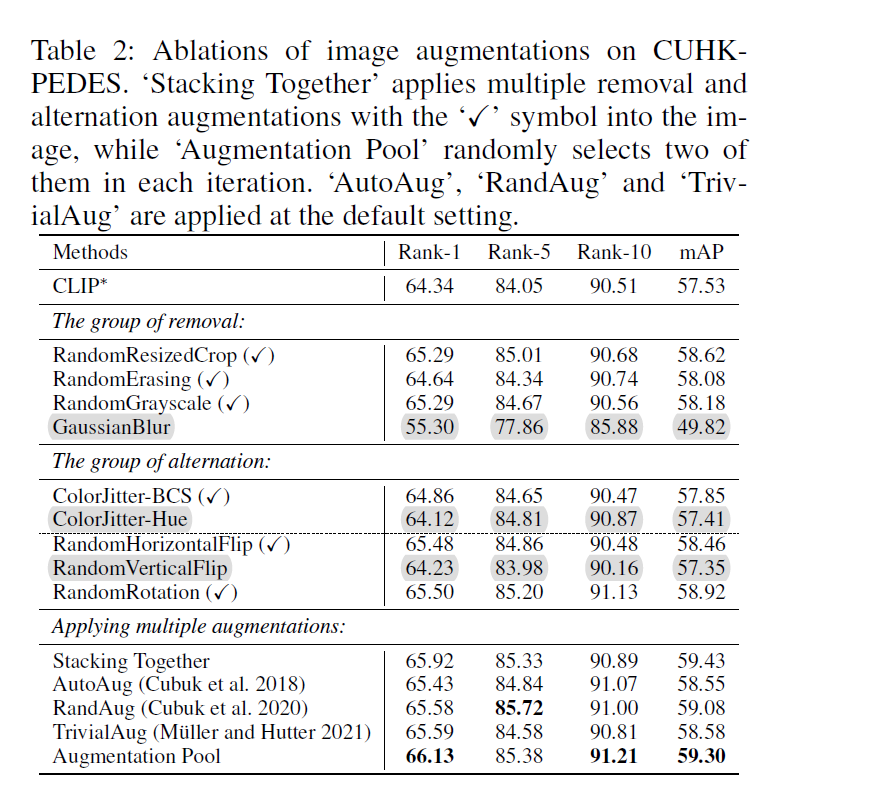

- The other SOTA methods have been experimented but is not as effective as the above methods:
    - Stacking Together: just apply sequentially these above methods
    - AutoAug:
        - From paper "AutoAugment: Learning Augmentation Policies from Data", CVPR 2019
        - Automatically search for the best data augmentation policy in a search space by reinforcement learning
    - RandAug:
        - From paper "RandAugment: Practical automated data augmentation with a reduced search space", CVPR 2020
        - An automated data augmentation method. The search space for data augmentation has hyperparameter $N, M$, that $N$ is the number of transformations can apply, $M$ is the scaled magnitude for all transformations. $N, M$ is sampled from a uniform distribution 
    - TrivialAug:
        - From paper "TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation", arXiv 2021

- Other experiment result:
    - RandomGrayScale eliminating  all color information from the image, *but* leads to improved result, while RandomColorJitter does not!
    - GaussianBlur, RandomVerticalFlip are also *not* effective
    - Each of 4 SOTA method above are effective, but the simplest __Augmentation Pool__, designed in this paper is the best!

## Text Augmentation

- Just a simple method: stacking __BackTranslation__ and __RandomDelete__ together
    - Use only 1 or combined 2 of these methods leads to better result than using no augmentation
    - RandomInsert, RandomSwap, SynonymReplacement are proved to be not effective

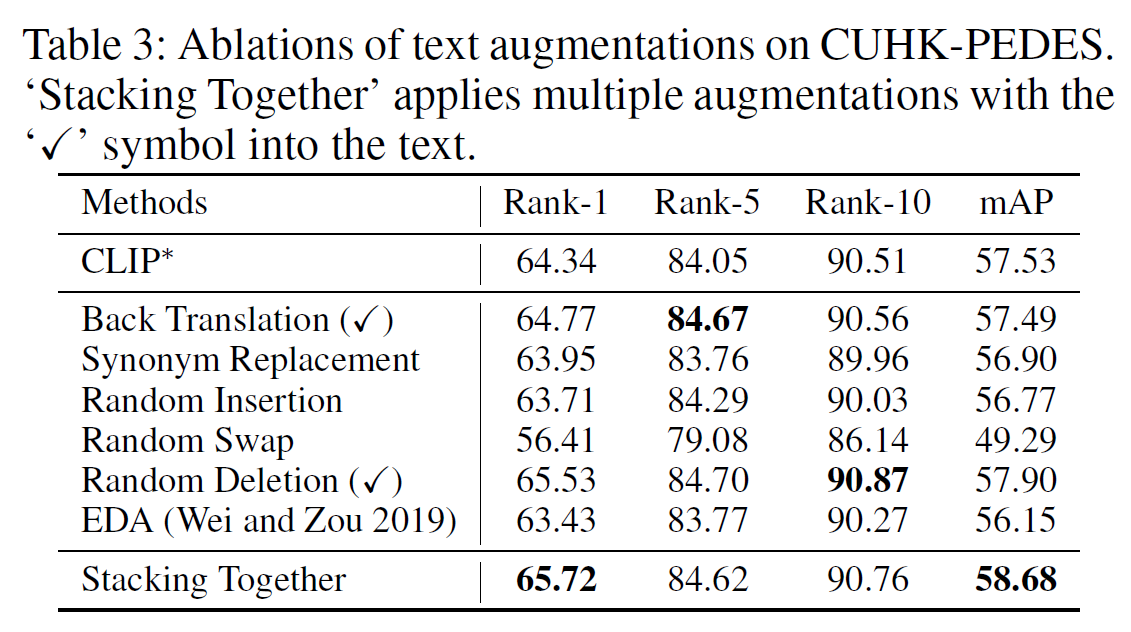

- Stacking two methods above is better than EDA method from paper "EDA: Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks", NAACL 2019
    - EDA is choose and perform 1 in 4 methods: 
        - Synonym Replacement
        - Random Insertion
        - Random Swap
        - Random Deletion
    - EDA is used in the SOTA paper APTM and is proved to boost result on all benchmarks
    - But in this paper, EDA is proved to be not as effective as (BackTranslation + RandomDelete)!!

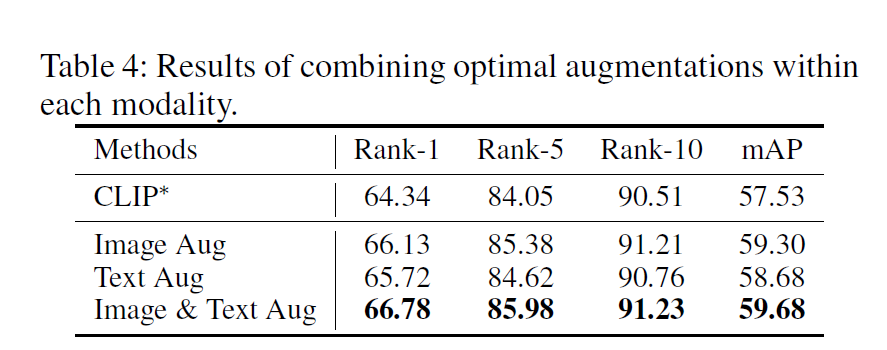

# Loss Functions

## Loss for Constrastive Learning

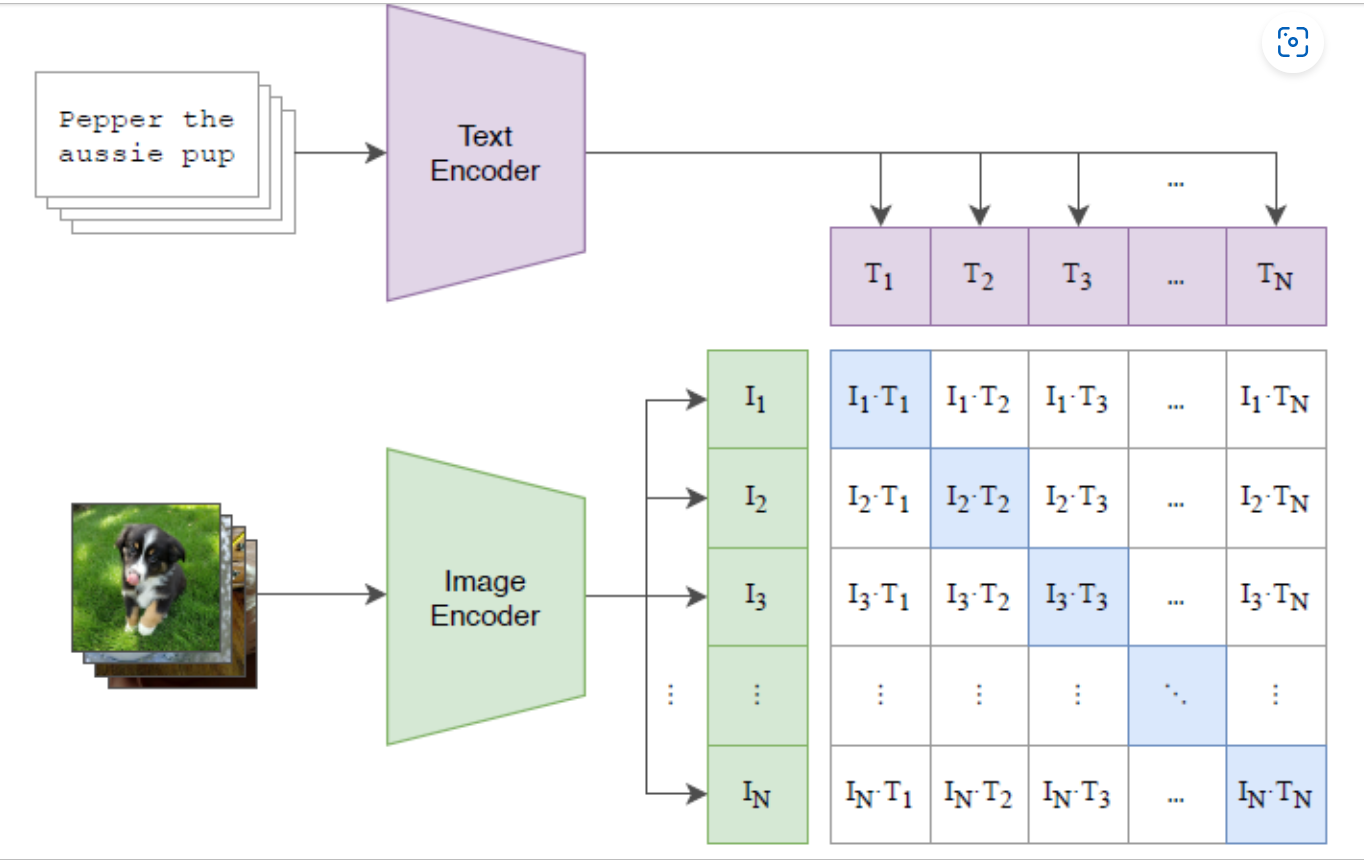

- Modified CLIP 's constrastive loss that was used for image-text constrastive learning:
    - CLIP consider the constrastive learning as two classification problem:
        - Classify the image belong to which text in minibatch
        - Classify the text belong to which image in minibatch
    - CLIP used cross-entropy loss for ground-true one-hot vector and the predicted probability vector, for each direction image2text or text2image
    - This paper just replace ground-true one-hot vector by the normalized soft label vector (replace one-hot label by soft label, then normalize) 
        - $L_{ITC}$ --> $L_{N-ITC}$
        
    <br>
    <br>
    
- Formula:
    $$
\mathcal{L}_{N-I T C}=-\frac{1}{2 N}\left(\sum_{i=1}^N \sum_{j=1}^N \hat{q}_{i, j} \log p_{i, j}+\sum_{i=1}^N \sum_{j=1}^N \hat{q}_{j, i} \log p_{j, i}\right)
$$
    - where:
        - $\hat{q}_{i, j}$ is normalized by $q_{i, j} / \sum_{k=1}^N q_{i, k}$ and $q_{i, j}$ is the soft label. 
        - $N$ is the number of samples
        - $p_{i, j}$ represents the pseudo-label that is the probability of matching the image $I_i$ to the text $T_j$ and the reverse applies in $p_{j, i}$,
$$
p_{i, j}=\frac{\exp \left(f_{I_i} \cdot f_{T_j} / \tau\right)}{\sum_{k=1}^N \exp \left(f_{I_i} \cdot f_{T_k} / \tau\right)}, p_{j, i}=\frac{\exp \left(f_{T_i} \cdot f_{I_j} / \tau\right)}{\sum_{k=1}^N \exp \left(f_{T_i} \cdot f_{I_k} / \tau\right)},
$$
where 
            - $f_*$ is the $\ell_2$-normalized representations of the sample
            - $\tau$ is the learnable temperature parameter.



## Loss for improving data efficiency

__Self-Supervision__

- The self-supervised loss (SS) aims at maximizing the similarity between two different augmentations of an image or prompts, --> learning robust feature representations with limited image data, no label is required
$$
\mathcal{L}_{S S}=-\frac{1}{2 N} \sum_{i=1}^{2 N} \log \frac{\exp \left(\operatorname{sim}\left(z_i, z_j\right) / \tau_s\right)}{\sum_{k=1, k \neq i}^{2 N} \exp \left(\operatorname{sim}\left(z_i, z_k\right) / \tau_s\right)}
$$

    - $z_i, z_j$ are feature representations of two augmentations of the sample.

- The SS can be applied on the image or text or both of them, denoted as SS-I, SS-T and SS-IT,

- The default SS loss is SS-I

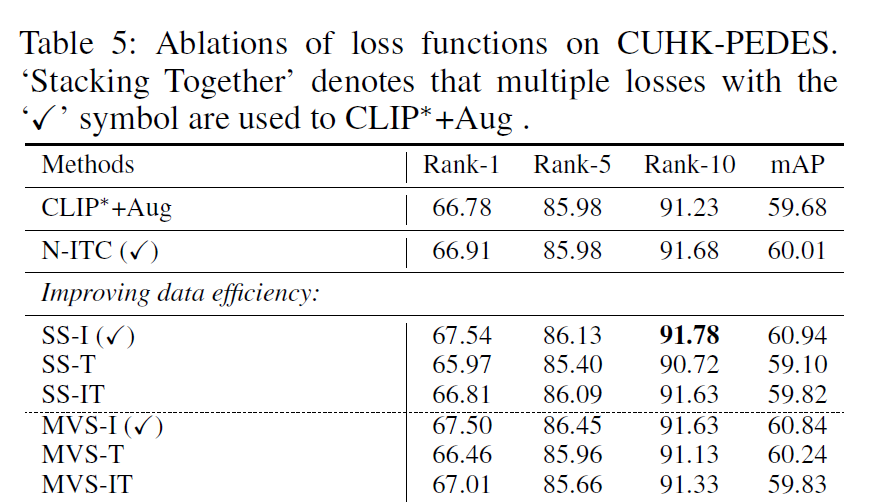

__Multi-view Supervision__

- Let $\tilde{I}$ and $\tilde{T}$ denote another differently augmented view of $I$ and $T$, the N-ITC can be applied on 
    - $(\tilde{I}, T)$: multi-view supervision loss of image (MVS-I)
    - $(I, \tilde{T})$: multi-view supervision loss of text (MVS-T)
    - $(\tilde{I}, \tilde{T})$: multi-view supervision loss of image and text (MVS-IT)
    
--> Just N-ITC loss for augmentation data

- Only choose the best in these 3 loss:
    - By experiment, choose MVS-I 

## Optimization for retrieval

__Reversed Image-Text Contrastive Loss (R-ITC)__

- N-ITC formula is roughly equivalent to optimize $D_{KL}(Q||P)$:
    - Recall CE loss formula: $$H(p, q) = H_{q}(p) = H(q || p)= \sum_{x} p(x) \log(\frac{1}{q(x)}) = - \sum_{x} p(x) \log(q(x))$$
    - Recall DL Divergence loss formula: $$D(q || p) = \sum_{x} p(x) \log(\frac{p(x)}{q(x)}) = - \sum_{x} p(x) \log(q(x))$$

- Reversed Image-Text Contrastive Loss is just optimizing $D_{KL}(Q||P)$

$$
\begin{aligned}
\mathcal{L}_{R-I T C} & =\frac{1}{2}\left(D_{\mathrm{KL}}\left(p_{i, j} \| \hat{q}_{i, j}\right)+D_{\mathrm{KL}}\left(p_{j, i} \| \hat{q}_{j, i}\right)\right) \\
& =\frac{1}{2 N}\left(\sum_{i=1}^N \sum_{j=1}^N p_{i, j} \log \frac{p_{i, j}}{\hat{q}_{i, j}+\epsilon}+\sum_{i=1}^N \sum_{j=1}^N p_{j, i} \log \frac{p_{j, i}}{\hat{q}_{j, i}+\epsilon}\right)
\end{aligned}
$$

__Cyclic Image-Text Contrastive Loss (C-ITC)__

Follow CyCLIP, aim to enhances geometrical consistency in data representation space

- For intra-modality

$$
\mathcal{L}_{C^I-I T C}=\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^N\left(\operatorname{sim}\left(I_i, I_j\right)-\operatorname{sim}\left(T_i, T_j\right)\right)^2
$$

- For cross-modality:
$$
\mathcal{L}_{C^C-I T C}=\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^N\left(\operatorname{sim}\left(I_i, T_j\right)-\operatorname{sim}\left(T_i, I_j\right)\right)^2
$$

- Final C-ITC loss:
    $$\mathcal{L}_{C^C-I T C} = \mathcal{L}_{C^C-I T C} + \mathcal{L}_{C^C-I T C}$$


## Final training loss

Final loss is the weighted sum of 5 losses: $L_{N-ITC}, L_{R-ITC}, L_{C-ITC}, L_{SS-I}, L_{MSV-I}$

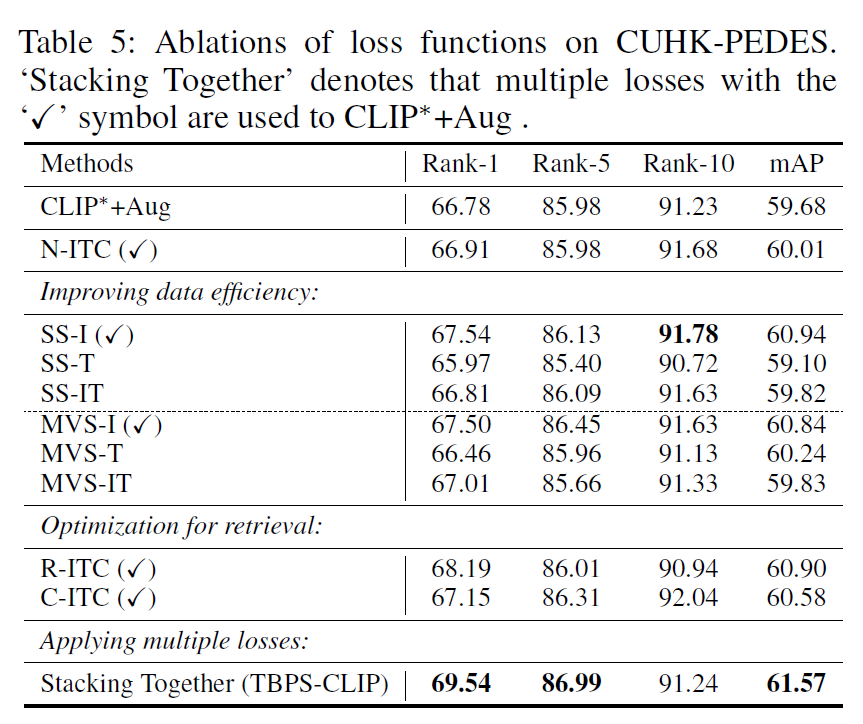

# Evaluation result

__Compared with 2 SOTA method in 2023__
IRRA (CVPR 2023), RaSa (ICJAI 2023)

- Just finetune for 5 epochs to beat SOTA method
- Low computional cost, low inference time, less trainable parameters compared to IRRA, RaSa

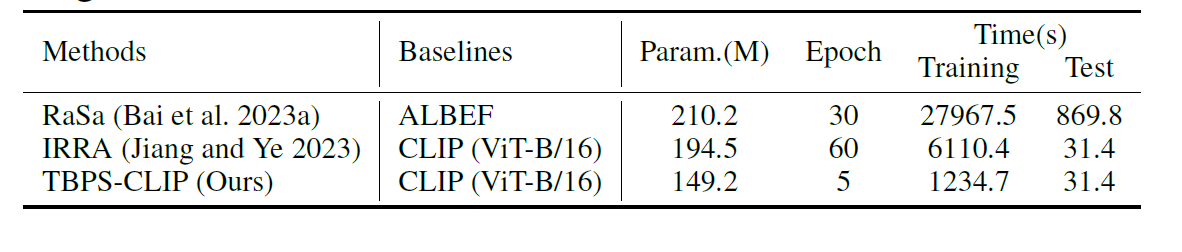

__Compared with the others__

- Simplified version of TBPR-CLIP is just using N-ITC and R-ITC loss

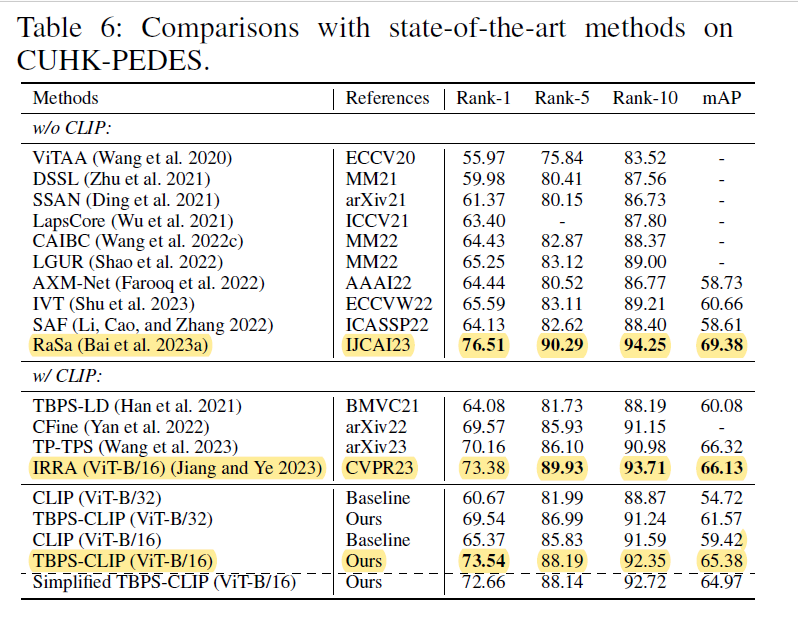

__Choose TBPR-CLIP as baseline of IRRA can boose IRRA 's result__

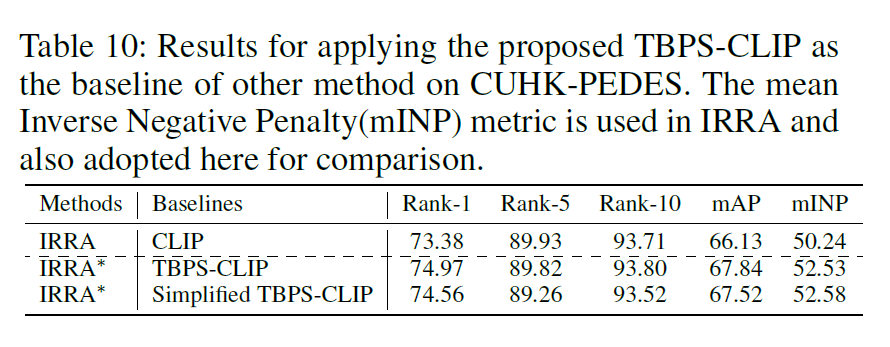

__Freezing some layers of the text encoder does
not have much impact on performance__

- The model can be compressed more for efficiency in lower computational cost

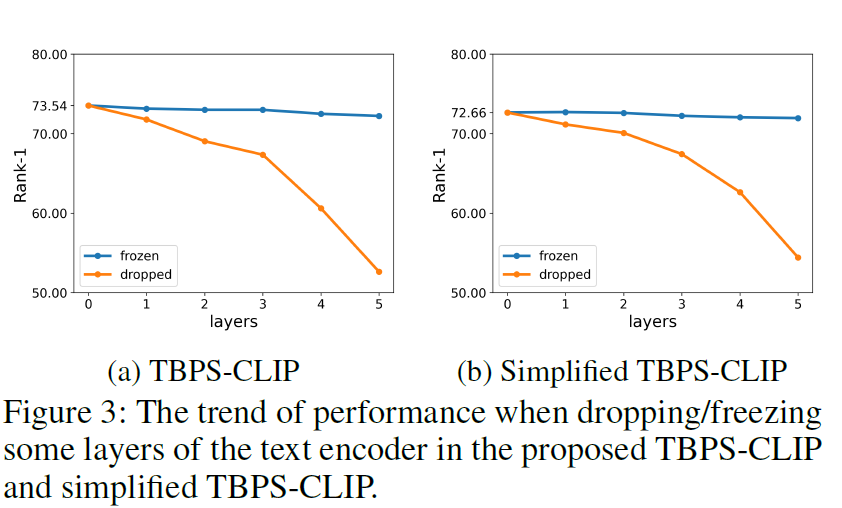

__Generation of model is better than original CLIP__

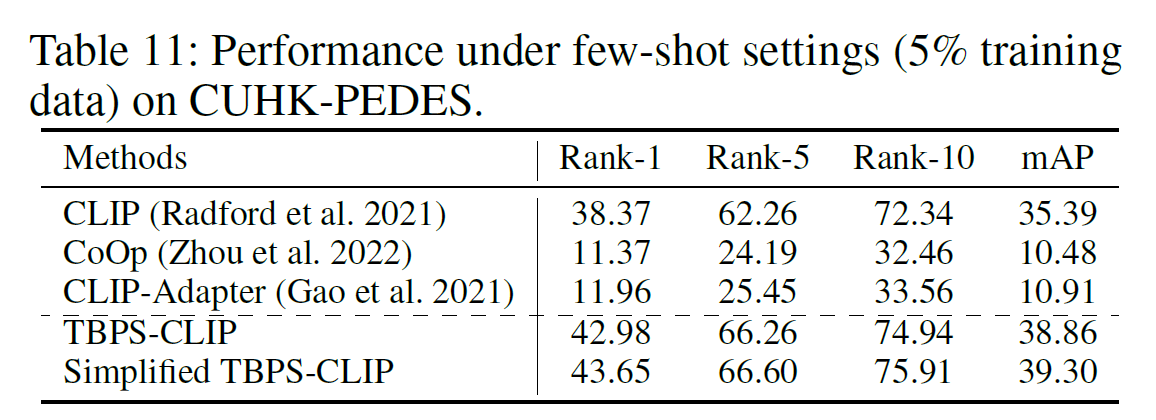

# Demo in notebook

Use "tbps-clip" kernel

## Set up

### Define path

In [1]:
import os, sys
print(os.getcwd())
from pathlib import Path
ROOT_PATH = Path('../paper_clones/TBPS-CLIP').resolve()
sys.path.append(str(ROOT_PATH))
IMAGE_PATH = Path('../DATASET').resolve()
sys.path.append(str(IMAGE_PATH))

/home/jovyan/workspace/BA-PRE_THESIS/REPORT


### Import libries / local modules

In [21]:
import os
from torchinfo import summary
import random
import time
from pathlib import Path
import torch
from misc.build import load_checkpoint, cosine_scheduler, build_optimizer
from misc.data import build_pedes_data
from misc.eval import test
from misc.utils import parse_config, init_distributed_mode, set_seed, is_master, is_using_distributed, AverageMeter
from model.tbps_model import clip_vitb
from options import get_args
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load config

In [66]:
config_path = ROOT_PATH/'config/config.yaml'
config = parse_config(config_path)
set_seed(config)
config['model']['checkpoint'] = ROOT_PATH/'checkpoint/ViT-B-16.pt'
config['anno_dir'] = ROOT_PATH/'annotation/ICFG-PEDES'
config['image_dir'] = IMAGE_PATH/'ICFG-PEDES/imgs'
config['device'] = 'cuda'
config['model']['use_gather'] = False
config['data']['batch_size'] = 16

### Build loader for ICFG-PEDES

In [68]:
dataloader = build_pedes_data(config)
train_loader = dataloader['train_loader']
num_classes = len(train_loader.dataset.person2text)

### Load model checkpoint

In [69]:
model = clip_vitb(config, num_classes).to('cuda')

In [70]:
model, load_result = load_checkpoint(model, config)

## View batchdata

In [71]:
train_batch = next(iter(train_loader))
list(train_batch.keys())

['image', 'caption', 'caption_bt', 'id', 'aug1', 'aug_ss_1', 'aug_ss_2']

In [72]:
example = train_loader.dataset[0]
for i, x in enumerate(example):
    if type(example[x]) == type(torch.Tensor()):
        print(i, x, example[x].shape)
    else:
        print(i, x, example[x])

0 image torch.Size([3, 224, 224])
1 caption a young age woman has black shoulder-length hair and her is wearing a long grey collar jacket with white rounded neck inside with black pants and black shoes
2 caption_bt a young woman has black shoulder hair and she wears a long grey collar with a white collar rounded inside with black pants and black shoes
3 id 0
4 aug1 torch.Size([3, 224, 224])
5 aug_ss_1 torch.Size([3, 224, 224])
6 aug_ss_2 torch.Size([3, 224, 224])


## Summary model

In [73]:
summary(model)

Layer (type:depth-idx)                                                 Param #
CLIP                                                                   1
├─VisualTransformer: 1-1                                               545,280
│    └─Conv2d: 2-1                                                     589,824
│    └─LayerNorm: 2-2                                                  1,536
│    └─Transformer: 2-3                                                --
│    │    └─Dropout: 3-1                                               --
│    │    └─Sequential: 3-2                                            85,054,464
│    └─LayerNorm: 2-4                                                  1,536
├─TextTransformer: 1-2                                                 301,568
│    └─Transformer: 2-5                                                --
│    │    └─Dropout: 3-3                                               --
│    │    └─Sequential: 3-4                                            37,828,6

In [74]:
modules = [x for x in dict(model.named_modules()).keys() if '.' not in x and len(x) > 0]
modules

['visual', 'encode_text', 'simclr_mlp']

__Feed batchdata into model__

In [ ]:
res = model(train_batch, alpha=0.5)

In [77]:
res

{'ss_loss': tensor(1.2128, device='cuda:0', grad_fn=<MulBackward0>),
 'nitc_loss': tensor(2.3698, device='cuda:0', grad_fn=<MulBackward0>),
 'citc_loss': tensor(0.0011, device='cuda:0', grad_fn=<MulBackward0>),
 'ritc_loss': tensor(2.4784, device='cuda:0', grad_fn=<MulBackward0>)}